In [1]:
from numpy import array
import numpy as np
import pandas as pd
from numpy import array

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

import matplotlib.pyplot as plt
%matplotlib inline
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers import Conv1D
from keras.layers import MaxPooling1D

Using TensorFlow backend.


1 Physical GPUs, 1 Logical GPUs


In [2]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        dataX.append(dataset[i:(i+look_back), 0])
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [3]:
look_back =8
data=pd.read_csv('gold_train.csv')
dataset = np.asarray(data[['price']])
scaler = MinMaxScaler(feature_range=(0, 1))
x_sample = [200, 2000]
scaler.fit(np.array(x_sample)[:, np.newaxis])
#dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
trainx, testy = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
train=scaler.transform(trainx)
test=scaler.transform(testy)
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(trainX.shape[0],trainX.shape[1])
s=int(trainX.shape[1]/2)
#print(trainX[1:3])
trainX = np.reshape(trainX, (trainX.shape[0], s,2,1)).astype('float32')
testX = np.reshape(testX, (testX.shape[0],s,2,1)).astype('float32')
#print(len(testX),len(testY))

8653 8


In [12]:
batch_size=16
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=26, kernel_size=1, activation='relu'), input_shape=(None,2,1)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
#model.add(LSTM(30, activation='relu',return_sequences=True))
model.add(LSTM(20, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


In [28]:
%%time
history=model.fit(trainX, trainY, epochs=1, batch_size=batch_size,validation_data=(testX, testY), shuffle=False)

Train on 8653 samples, validate on 2158 samples
Epoch 1/1
8653/8653 [==============================] - 12s 1ms/step - loss: 1.6651e-04 - val_loss: 3.3407e-04
Wall time: 11.7 s


In [29]:
trainScore = model.evaluate(trainX, trainY, batch_size=batch_size, verbose=0)
print('Train Score: ', trainScore)
testScore = model.evaluate(testX, testY, batch_size=batch_size, verbose=0)
#print(testX[:252])
print('Test Score: ', testScore)

Train Score:  0.0032781781148698017
Test Score:  0.00033407297824961834


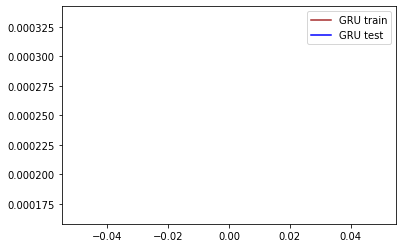

In [30]:
plt.plot(history.history['loss'], label='GRU train', color='brown')
plt.plot(history.history['val_loss'], label='GRU test', color='blue')
plt.legend()
plt.show()

In [31]:
input=test[test_size-look_back:]
r_data=pd.read_csv('gold_july.csv').values
size=r_data.size
s=int(look_back/2)
predicted_y=[]
for i in range(size):
    #print(input)
    input_lstm=np.reshape(input[i:look_back+i],newshape=1*look_back)
    input_lstm=np.reshape(input_lstm, (1,s,2,1))
    #print(input_lstm)
    y=model.predict(input_lstm,verbose=0)
    #print(y)
    input=np.append(input,y[0])
    y=scaler.inverse_transform(y)
    predicted_y.append(y[0])
    #print(predicted_y)
    #i=i+1

#print(scaler.transform(r_data))

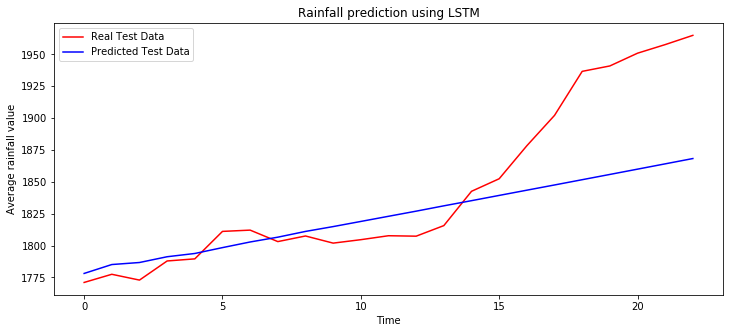

In [32]:
plt.figure(figsize=(12,5))
plt.plot(r_data, color = 'red', label = 'Real Test Data')
plt.plot(predicted_y, color = 'blue', label = 'Predicted Test Data')
plt.title('Rainfall prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Average rainfall value')
plt.legend()
plt.show()

In [33]:
input=test[test_size-look_back:]
r_data=pd.read_csv('gold_july.csv').values
size=r_data.size
predicted_1y=[]
for i in range(size):
    #print(input)
    input_lstm=np.reshape(input[i:look_back+i],newshape=1*look_back)
    input_lstm=np.reshape(input_lstm, (1,s,2,1))
    #print(input_lstm)
    y=model.predict(input_lstm,verbose=0)
    x=scaler.transform([r_data[i]])
    input=np.append(input,x)
    y=scaler.inverse_transform(y)
    predicted_1y.append(y[0])
    #print(predicted_y)
    #i=i+1

#print(scaler.transform(r_data))

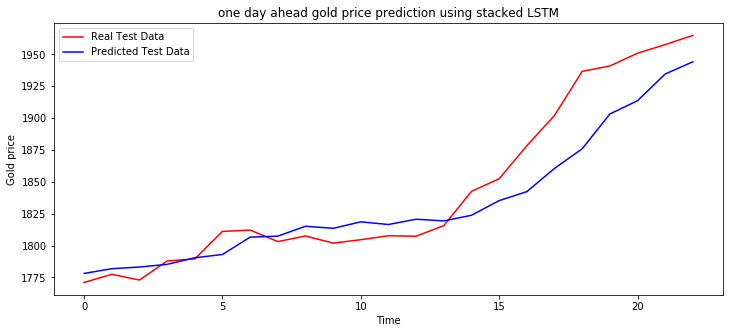

In [34]:
plt.figure(figsize=(12,5))
plt.plot(r_data, color = 'red', label = 'Real Test Data')
plt.plot(predicted_1y, color = 'blue', label = 'Predicted Test Data')
plt.title('one day ahead gold price prediction using stacked LSTM')
plt.xlabel('Time')
plt.ylabel('Gold price')
plt.legend()
plt.show()

In [27]:
import pickle
filename = 'cnnlstm_gold.sav'
pickle.dump(model, open(filename, 'wb'))